
### Librerías

In [60]:
import sys
import pandas as pd
import GetOldTweets3 as got
#from ipynb.fs.full.GetOldTweets import *
import sys
import matplotlib.pyplot as plt

### Configuración de parámetros 

In [61]:
pd.options.display.max_columns = 5000
pd.options.display.max_rows = 5000

### Ejecución de códigos auxiliares

In [62]:
%run Metodos_Propios.ipynb
%run Gestion_Ficheros.ipynb
%run GetOldTweets.ipynb
%run NLP.ipynb

# Método Principal - TFM Data Science

In [55]:
if __name__ == '__main__':
    # Definición de variables
    df_tweets, df_tweets_time = creacion_DataFrame()
    calendario = calendar()
    positivo, negativo, neutral, sentiment = creacion_Variables()
    
    #Acceso a Twitter
    api = acceso_Twitter() 
    
    #Lectura de ficheros para ir más rápido ubicados en CSVs
    df_tweets = read_all_Tweets() 
    #df_tweets = read_Tweets()
    #print(calendario)
    #Obtención por GetOldTweets
    #df_tweets = get_Tweets(calendario)
    
    #Pasando el algoritmo de NLP para obtener el análisis de sentimiento
    sentiment = analisis(df_tweets, positivo,neutral,negativo)
    #Generación de CSVs para el CdM

Positivo: 5.024374501044622 %
Negativo: 1.6459157848249621 %
Neutral: 93.32970971413042 %


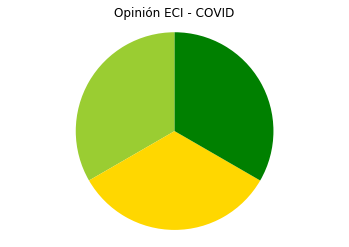

In [63]:
pintar(sentiment[positivo], sentiment[neutral], sentiment[negativo])

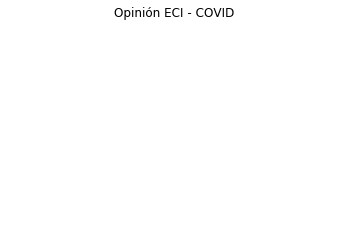

In [64]:
labels = ['Positivo ['+str(sentiment[positivo])+'%]','Neutral ['+str(sentiment[neutral])+'%]','Negativo ['+str(sentiment[negativo])+'%]']
sizes = [positivo,neutral,negativo]
colors =['yellowgreen','gold','green']
patches, texts = plt.pie(sizes, colors=colors, startangle=90)
plt.title('Opinión ECI - COVID')
plt.axis('equal')
plt.show()